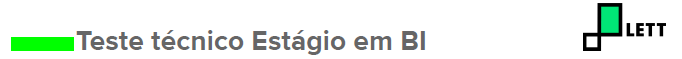

# - **Candidato:** Francisco Flávio Cardoso Gomes
# - **Tarefa:** Explorar os dados e buscar insights sobre a satisfação dos clientes que compram no e-commerce no Brasil 
# - **Dataset:** Brazilian E-Commerce Public Dataset by Olist


Algumas visualizações deste notebook foram adaptadas dos notebooks abaixo:
* https://www.kaggle.com/krnilo/customer-reviews-analysis-brazilian-e-commerce;
* https://www.kaggle.com/rafanthx13/reviewer-of-product-comments-in-portuguese;
* https://colab.research.google.com/drive/1-oImUwjLWbEq70-AapRsDVbmsdvCQKcl#scrollTo=p-6xLhSRC8Mg;
* https://colab.research.google.com/drive/1m4h0j-pFPm3nvPs0tKpVB0kxHnNC_Ry0#scrollTo=lN8rTLbiv7CT

#1. Análise exploratória e Modelagem dos dados

Importação das bibliotecas necessárias

In [1]:
import numpy as np 
import pandas as pd 
%matplotlib inline 
import plotly.express as px
import json
from urllib.request import urlopen
import random
from PIL import Image
from datetime import datetime
import unicodedata
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

Leitura dos dados

In [2]:
order_items = pd.read_csv('/content/olist_order_items_dataset.csv')
order_reviews = pd.read_csv('/content/olist_order_reviews_dataset.csv')
orders = pd.read_csv('/content/olist_orders_dataset.csv')
products_dataset = pd.read_csv('/content/olist_products_dataset.csv')


Resumindo as informações dos datasets

In [3]:
datasets = [order_items, order_reviews, orders, products_dataset]
titles = ["Order items", "Order reviews","Orders", "Products"]

info_df = pd.DataFrame({},)
info_df['dataset']= titles
info_df['cols'] = [', '.join([col for col, null in df.isnull().sum().items() ]) for df in datasets]
info_df['cols_no']= [df.shape[1] for df in datasets]
info_df['null_no']= [df.isnull().sum().sum() for df in datasets]
info_df['null_cols_no']= [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
info_df['null_cols'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
info_df['duplicated'] = [df.duplicated().sum() for df in datasets]
info_df



,dataset,cols,cols_no,null_no,null_cols_no,null_cols,duplicated
0,Order items,"order_id, order_item_id, product_id, seller_id...",7,0,0,,0
1,Order reviews,"review_id, order_id, review_score, review_comm...",7,146532,2,"review_comment_title, review_comment_message",0
2,Orders,"order_id, customer_id, order_status, order_pur...",8,4908,3,"order_approved_at, order_delivered_carrier_dat...",0
3,Products,"product_id, product_category_name, product_nam...",9,2448,8,"product_category_name, product_name_lenght, pr...",0


Como vemos existem dados nulos em todos os datasets, exceto em order_items. Não existem dados duplicados. Vamos examinar os dados nulos de cada dataset

##1.1. Dataset orders


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


O dataset orders contém as datas de cada etapa do pedido. Como estas datas estão no formato de string vamos transformar para datetime

In [5]:
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])


Agora vamos investigar os valores nulos existentes

In [6]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Na verdade, existem valores nulos em várias das colunas do tipo data (pedido aprovado, data de entrega ao entregador, data de entrega ao cliente). No entanto, não parecem ser erros, mas correspondem aos status dos pedidos.
Vamos verificar se os status dos pedidos estão corretos de acordo com as datas de entrega.

In [7]:
orders['order_status'].value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

Vamos começar com os pedidos que têm o campo data de aprovação do pedido, vazio. Todos esses pedidos devem estar nos status 'criado', 'cancelado' ou 'indisponível'. Vamos checar:

In [8]:
orders[orders['order_approved_at'].isna()]['order_status'].value_counts()

canceled     141
delivered     14
created        5
Name: order_status, dtype: int64

No entanto, encontramos 14 pedidos que foram entregues (order_status = 'delivered'), mas sem data de aprovação . Este parece ser um erro que devemos corrigir.
Para consertar, por enquanto, podemos substituir a data de aprovação pela data do pedido, como se houvesse uma aprovação automática.

Vamos criar um filtro com estes 14 pedidos que não possuem data de aprovação mas estão com o status de entregue


In [9]:
filtro1 = ((orders['order_approved_at'].isna()) & (orders['order_status']=='delivered'))

Vamos modificar o valor do campo data de aprovação com este filtro para o valor do campo data do pedido

In [10]:
orders.loc[filtro1, 'order_approved_at'] = orders.loc[filtro1, 'order_purchase_timestamp']

In [11]:
orders[orders['order_approved_at'].isna()]['order_status'].value_counts()

canceled    141
created       5
Name: order_status, dtype: int64

Verificamos que agora os pedidos com o campo data de aprovação nulos correspondem aos pedidos com o status correto (Cancelado ou criado).

Agora vamos olhar o campo data da entrega a transportadora.


In [12]:
orders[orders['order_delivered_carrier_date'].isna()]['order_status'].value_counts()

unavailable    609
canceled       550
invoiced       314
processing     301
created          5
delivered        2
approved         2
Name: order_status, dtype: int64

Existem 2 pedidos entregues ao cliente, mas sem data de entrega à transportadora. Assumindo o mesmo de antes, nós os corrigiremos atribuindo a eles a data de aprovação do pedido. Vejamos os dois pedidos

Crie um filtro com estes 2 pedidos
Vamos criar um filtro com estes 2 pedidos que não possuem data da entrega à transportadora mas estão com o status de entregue ao cliente

In [13]:
filter2 = ((orders['order_delivered_carrier_date'].isna()) & (orders['order_status']=='delivered'))


Vamos modificar o valor do campo data de entrega à transportadora com este filtro para o valor da data de aprovação.

In [14]:
orders.loc[filter2, 'order_delivered_carrier_date'] = orders.loc[filter2, 'order_approved_at']

In [15]:
orders[orders['order_delivered_carrier_date'].isna()]['order_status'].value_counts()

unavailable    609
canceled       550
invoiced       314
processing     301
created          5
approved         2
Name: order_status, dtype: int64

Agora vamos dar uma olhada na data de entrega ao cliente

In [16]:
orders[orders['order_delivered_customer_date'].isna()]['order_status'].value_counts()

shipped        1107
canceled        619
unavailable     609
invoiced        314
processing      301
delivered         8
created           5
approved          2
Name: order_status, dtype: int64

Existem 8 pedidos que têm uma data de entrega do cliente vazia, mas estão com o status 'entregue'.

Vamos criar um filtro com estes 8 pedidos que não possuem data de entrega mas estão com o status de entregue




In [17]:
filter3 = ((orders['order_delivered_customer_date'].isna()) & (orders['order_status']=='delivered'))

Para corrigir podemos fazer uma substituição adicionando à data de entrega o tempo médio de entrega do resto das encomendas. Teremos que adicionar uma coluna que é a diferença entre a data de entrega ao cliente e a data de entrega à transportadora e em seguida calcular o tempo médio de entrega




In [18]:
orders['carrier_time'] = orders['order_delivered_customer_date'] - orders['order_delivered_carrier_date']

In [19]:
avg_carrier_time = orders['carrier_time'].mean()
avg_carrier_time

Timedelta('9 days 07:56:37.863665576')

E agora modificamos o valor do campo data de entrega do pedido ao cliente  com este filtro para o valor do campo data de entrega à transportadora + o tempo médio de entrega, calculado acima.

In [20]:
orders.loc[filter3, 'order_delivered_customer_date'] = orders.loc[filter3, 'order_delivered_carrier_date']+avg_carrier_time
orders.loc[filter3, 'carrier_time'] = avg_carrier_time



Vamos salvar este dataset para possível uso no futuro

In [21]:
orders.to_csv('olist_cleaned_orders_dataset.csv')

## 1.2. Dataset order_reviews

In [22]:
order_reviews.isna().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

Existem valores nulos nos comentários. Iremos tratar disso quando formos fazer análise dos mesmos. Por enquanto vamos transformar os campos que contém datas para datetime.

In [23]:
order_reviews['review_creation_date'] = pd.to_datetime(order_reviews['review_creation_date'], format='%Y/%m/%d %H:%M:%S')
order_reviews['review_answer_timestamp'] = pd.to_datetime(order_reviews['review_answer_timestamp'], format='%Y/%m/%d %H:%M:%S')

## 1.3. Dataset products

In [24]:
products_dataset.isna().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

Existem alguns dados nulos neste dataset. Trataremos posteriormente, caso tenhamos que usá-lo.

#2. Análises e visualizações da satisfação do cliente




##2.1. Análise e visualização a partir dos scores das avaliações

Primeiro vamos definir a paleta que será aplicada na maioria das visualizações. Esta paleta é favorável à pessos daltônicas

In [25]:
sns.set()
COLOR_5S = '#0571b0'
COLOR_1S = '#ca0020'
REVIEWS_PALETTE = sns.color_palette((COLOR_1S, '#d57b6f', '#c6c6c6', '#7f9abc', COLOR_5S))
sns.set_style('darkgrid', {'axes.facecolor': '#eeeeee'})
resize_plot = lambda: plt.gcf().set_size_inches(12, 5)

Em seguida fazemos o merge dos dataset orders e order_reviews, mesclando-os para que tenhamos mais informações para fazer nossa análise e removemos colunas que não serão utilizadas no momento.

In [26]:
reviews = order_reviews
reviews = pd.merge(reviews, orders, on='order_id')

to_drop = [
    'review_id', 
    'order_id', 
    'customer_id', 
    'review_comment_title', 
    'order_approved_at', 
    'order_delivered_carrier_date', 
    'order_estimated_delivery_date'
]
reviews.drop(columns=to_drop, inplace=True)

In [27]:
reviews

,review_score,review_comment_message,review_creation_date,review_answer_timestamp,order_status,order_purchase_timestamp,order_delivered_customer_date,carrier_time
0,4,NaN,2018-01-18,2018-01-18 21:46:59,delivered,2018-01-11 15:30:49,2018-01-17 18:42:41,4 days 20:45:19
1,5,NaN,2018-03-10,2018-03-11 03:05:13,delivered,2018-02-28 12:25:19,2018-03-09 23:17:20,7 days 04:09:05
2,5,NaN,2018-02-17,2018-02-18 14:36:24,delivered,2018-02-03 09:56:22,2018-02-16 17:28:48,10 days 01:10:20
3,5,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06,delivered,2017-04-09 17:41:13,2017-04-20 09:08:35,9 days 18:43:48
4,5,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53,delivered,2018-02-10 10:59:03,2018-02-28 16:33:35,12 days 20:57:21
...,...,...,...,...,...,...,...,...
99995,5,NaN,2017-12-09,2017-12-11 20:06:42,delivered,2017-12-03 21:45:23,2017-12-08 17:19:00,0 days 22:01:31
99996,5,"Excelente mochila, entrega super rápida. Super...",2018-03-22,2018-03-23 09:10:43,delivered,2018-03-18 09:52:19,2018-03-21 17:44:08,1 days 17:52:39
99997,4,NaN,2018-07-01,2018-07-02 12:59:13,delivered,2018-06-22 16:47:28,2018-06-30 12:57:51,4 days 23:59:51
99998,1,Solicitei a compra de uma capa de retrovisor c...,2017-12-15,2017-12-16 01:29:43,delivered,2017-12-10 18:44:23,2017-12-14 22:04:30,2 days 03:58:49


Temos os dois conjuntos de dados mesclados, como pode ser visto acima. Observe que alguns comentários estão em branco. 

Vamos extrair ano, mês, dia e hora do dataset orders e criar a variável period, representando o mes/ano.

In [28]:
orders['order_purchase_year'] = pd.to_datetime(orders['order_purchase_timestamp']).dt.year
orders['order_purchase_month'] = pd.to_datetime(orders['order_purchase_timestamp']).dt.month
orders['order_purchase_day'] = pd.to_datetime(orders['order_purchase_timestamp']).dt.day
orders['order_purchase_hour'] = pd.to_datetime(orders['order_purchase_timestamp']).dt.hour

orders = orders[['order_id', 'order_purchase_year', 'order_purchase_month']]
orders = orders.groupby(['order_purchase_month', 'order_purchase_year']).count().reset_index()
orders = orders.sort_values(by=['order_purchase_year', 'order_purchase_month'])
orders["period"] =  orders["order_purchase_month"].astype(str) + "/" + orders["order_purchase_year"].astype(str)
orders.head()

,order_purchase_month,order_purchase_year,order_id,period
16,9,2016,4,9/2016
19,10,2016,324,10/2016
23,12,2016,1,12/2016
0,1,2017,800,1/2017
2,2,2017,1780,2/2017


###2.1.1 Estatísticas básicas das avaliações

In [29]:
reviews.describe()

,review_score,carrier_time
count,100000.000000,97021
mean,4.070890,9 days 08:02:39.647745413
std,1.359663,8 days 18:12:37.275356533
min,1.000000,-17 days +21:41:31
25%,4.000000,4 days 02:29:16
50%,5.000000,7 days 02:26:23
75%,5.000000,12 days 00:50:10
max,5.000000,205 days 04:35:00


In [30]:
orders.groupby(['order_purchase_year']).sum()

,order_purchase_month,order_id
order_purchase_year,,
2016,31,329
2017,78,45101
2018,55,54011


In [31]:
p_5s = len(reviews[reviews['review_score'] == 5]) * 100 / len(reviews)
p_1s = len(reviews[reviews['review_score'] == 1]) * 100 / len(reviews)
first_dt = reviews['review_creation_date'].min()
last_dt = reviews['review_creation_date'].max()
avg_s = reviews['review_score'].mean()
print('Total de avaliações    =>',len(reviews))
print('Primeira avaliação     =>', first_dt)
print('Última avaliação       =>', last_dt)
print(f'Percentual de score 5  => {p_5s:.1f}%')
print(f'Percentual de score 1  => {p_1s:.1f}%')
print(f'Score Médio            => {avg_s:.1f}')

Total de avaliações    => 100000
Primeira avaliação     => 2016-10-02 00:00:00
Última avaliação       => 2018-08-31 00:00:00
Percentual de score 5  => 57.4%
Percentual de score 1  => 11.9%
Score Médio            => 4.1


Há 100 mil avaliações em nosso dataframe, com uma nota média de 4,1.



###2.1.2 Percentual entre clientes satisfeitos e insatisfeitos



Vamos reduzir os scores para 0(negativo score abaixo de 3) e 1(positivo score maior ou igual a 3) e em seguida plotar os gráficos de barra e de pizza


In [32]:
new_reviews = reviews.copy()
def partition(x):
    if x < 3:
        return 0
    return 1
new_reviews['review_score']=new_reviews['review_score'].map(lambda cw : partition(cw) ) 
new_reviews.review_score.value_counts()

1    84907
0    15093
Name: review_score, dtype: int64

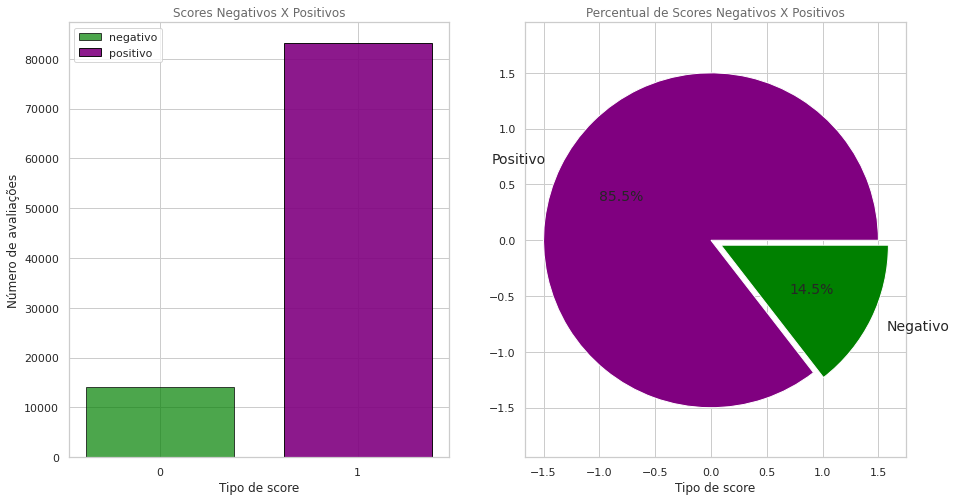

In [33]:
y_value_counts = new_reviews.review_score.value_counts()

%matplotlib inline
sns.set_style("whitegrid")
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.ylabel('Número de avaliações')
plt.xlabel('Tipo de score')
plt.title('Scores Negativos X Positivos',color='dimgrey')
plt.xticks([10,10.20],['0','1'])

#creating bar plots
plt.bar(10,14112, color = 'green', width = 0.15,alpha=0.7,label='negativo',edgecolor='black')
plt.bar(10.20,83143,color = 'purple', width = 0.15,alpha=0.9,label='positivo',edgecolor='black')
plt.legend()

plt.subplot(1,2,2)
labels = ['Positivo','Negativo']
sizes = [83143,14112]
explode = (0, 0.1)  # somente "explode" a segunda fatia 
color={'purple','green'}
plt.pie(sizes,explode=explode ,colors=color,labels=labels, autopct='%1.1f%%',shadow=False, startangle=0,radius=1.5,labeldistance=1.1,textprops={'fontsize': 14},frame=True, )
plt.axis('equal')  # A proporção 'equal' garante que a pizza seja desenhada como um círculo
plt.title('Percentual de Scores Negativos X Positivos',color='dimgrey')
plt.xlabel('Tipo de score')
plt.show()

Verifica-se que mais de 85% das avaliações são positivas

###2.1.3 Evolução dos pedidos no tempo

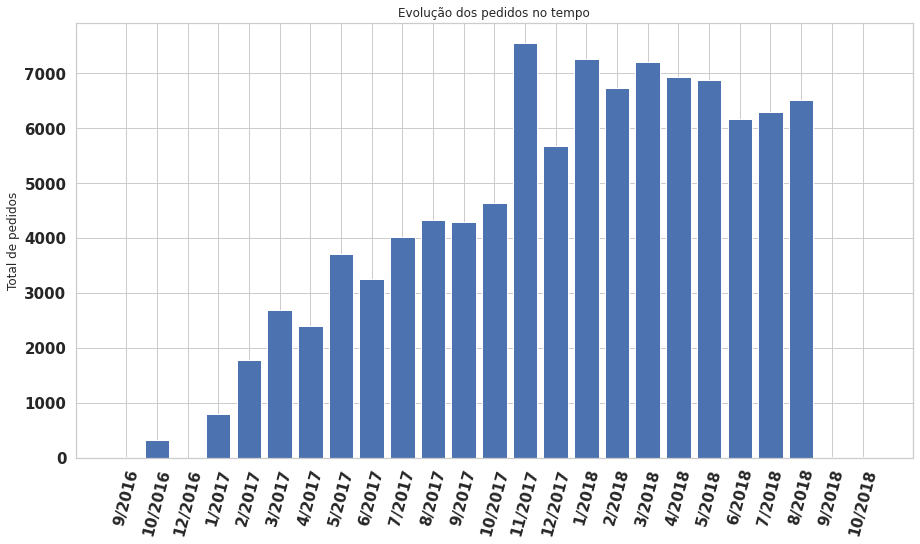

In [34]:
plt.figure(figsize=(15,8))
plt.bar(orders['period'], orders['order_id'])
plt.title('Evolução dos pedidos no tempo')
plt.ylabel('Total de pedidos')
plt.xticks(rotation=75, fontsize=15, weight='bold')
plt.yticks(fontsize=15, weight='bold')
plt.show()

Podemos ver o crescimento nos pedidos no final de 2017 e uma pequena queda a partir do meio do ano de 2018

###2.1.4. Número de avaliações X valor do score

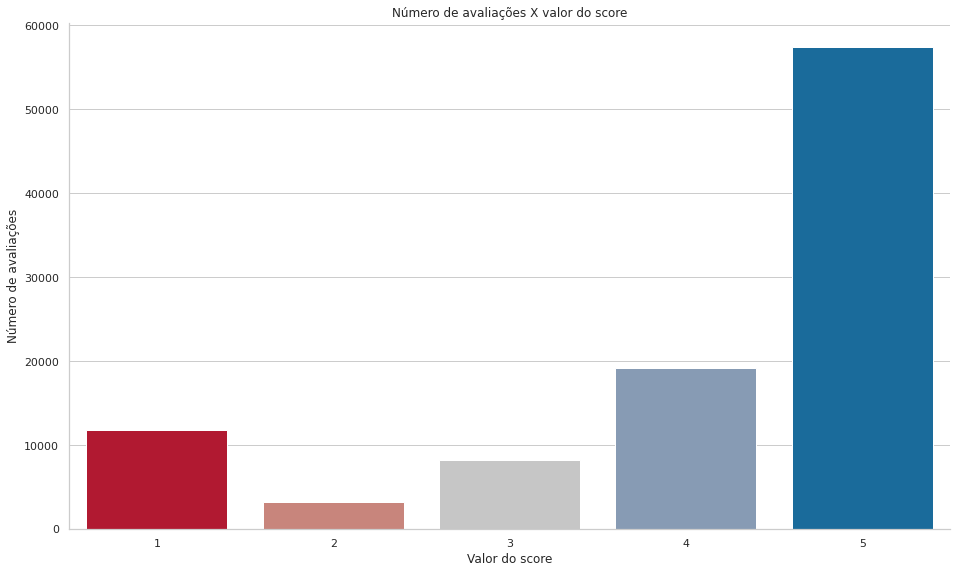

In [35]:
ax=sns.catplot(
    x='review_score', 
    kind='count', 
    data=reviews, 
    palette=REVIEWS_PALETTE
).set(
    xlabel='Valor do score', 
    ylabel='Número de avaliações',
    title='Número de avaliações X valor do score'
);
ax.fig.set_figwidth(15)
ax.fig.set_figheight(8)

É interessante observar que a maioria dos scores tem valor 5

###2.1.5 Número de avaliações X Score para status da compra = entregue


In [36]:
reviews.groupby('order_status')['order_status'].count()

order_status
approved           2
canceled         629
created            5
delivered      97015
invoiced         318
processing       302
shipped         1118
unavailable      611
Name: order_status, dtype: int64

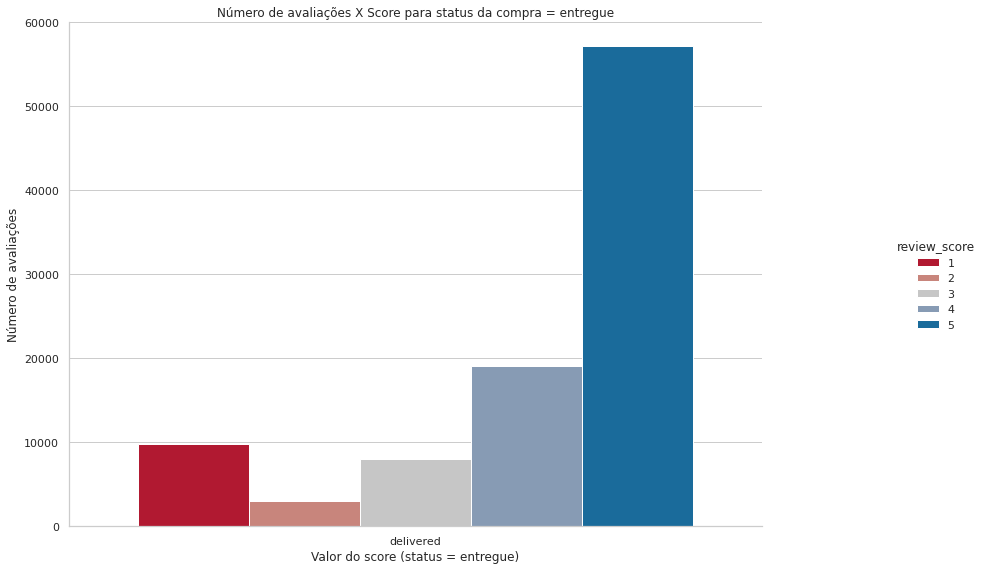

In [37]:
ax = sns.catplot(
    x='order_status',
    kind='count',
    hue='review_score',
    data=reviews[reviews['order_status'] == 'delivered'],
    palette=REVIEWS_PALETTE
).set(xlabel='Valor do score (status = entregue)', ylabel='Número de avaliações',title='Número de avaliações X Score para status da compra = entregue');
resize_plot()
ax.fig.set_figwidth(15)
ax.fig.set_figheight(8)

Vemos que para os pedidos com um status de 'entregue', a maioria  tem score =  5

###2.1.6 Número de avaliações X Score para status da compra = não entregue


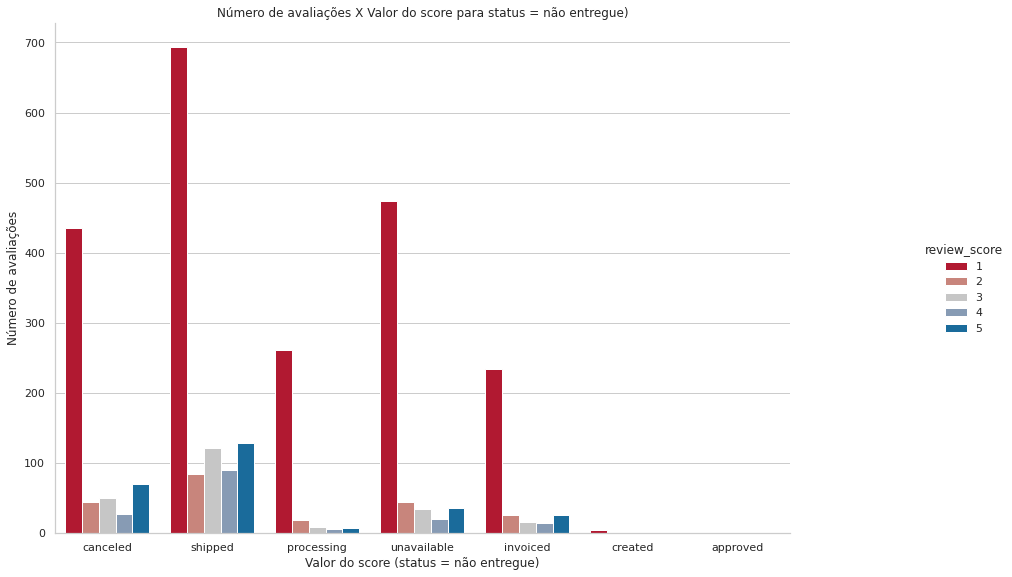

In [38]:
ax = sns.catplot(
    x='order_status',
    kind='count',
    hue='review_score',
    data=reviews[reviews['order_status'] != 'delivered'],
    palette=REVIEWS_PALETTE
).set(xlabel='Valor do score (status = não entregue)', ylabel='Número de avaliações',title='Número de avaliações X Valor do score para status = não entregue)');
resize_plot()
ax.fig.set_figwidth(15)
ax.fig.set_figheight(8)

Vemos que para os pedidos com um status diferente de 'entregue', a maioria  tem score =  1

###2.1.7 Tempo que o cliente leva para avaliar a compra




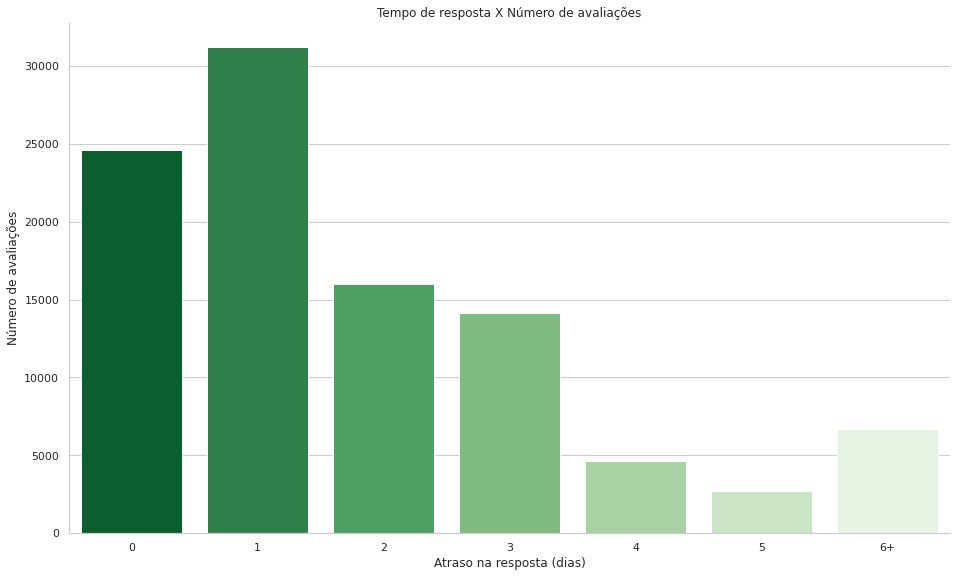

In [39]:
reviews['delay'] = (reviews['review_answer_timestamp'] - reviews['review_creation_date']).dt.days

bins = [-1, 0, 1, 2, 3, 4, 5, 99999]
labels = ['0', '1', '2', '3', '4', '5', '6+']
reviews['delay_group'] = pd.cut(reviews['delay'], bins, labels=labels)

ax=sns.catplot(
    x='delay_group', 
    kind='count', 
    data=reviews, 
    palette=sns.color_palette('Greens_r', n_colors=7)
).set(xlabel='Atraso na resposta (dias)', ylabel='Número de avaliações',title='Tempo de resposta X Número de avaliações');
ax.fig.set_figwidth(15)
ax.fig.set_figheight(8)

Podemos verificar que a maioria responde nos primeiros 3 dias após a compra



###2.1.8 Tempo que o cliente leva para avaliar a compra em função do score


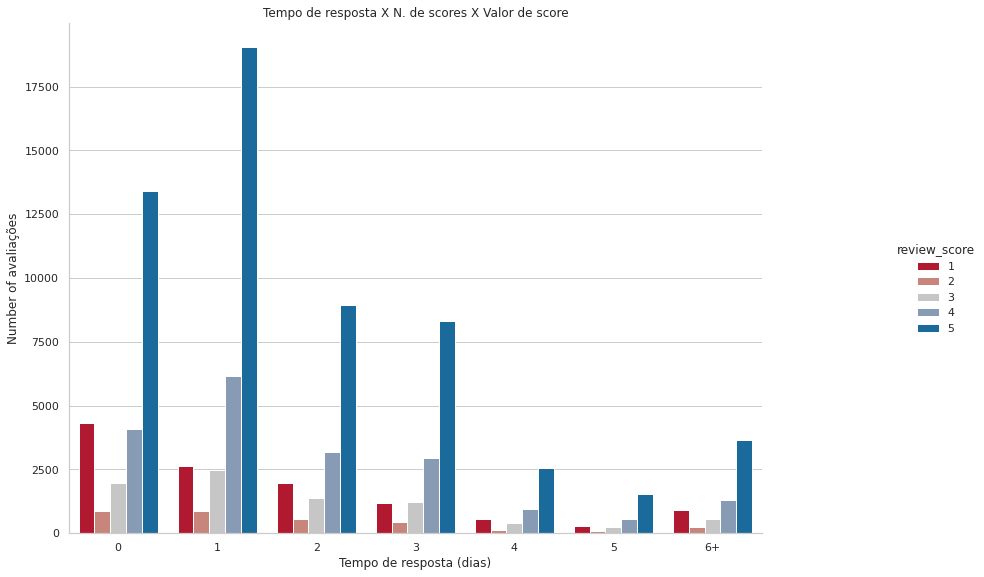

In [40]:
ax=sns.catplot(
    x='delay_group', 
    kind='count', 
    hue='review_score', 
    data=reviews, 
    palette=REVIEWS_PALETTE
).set(xlabel='Tempo de resposta (dias)', ylabel='Number of avaliações',title='Tempo de resposta X N. de scores X Valor de score');
resize_plot()
ax.fig.set_figwidth(15)
ax.fig.set_figheight(8)

Embora a maioria dos clientes espere um dia antes de responder, os clientes insatisfeitos (avaliações 1) têm maior probabilidade de responder no mesmo dia.

##2.2. Análise e visualizações a partir dos comentários

Começaremos calculando a duração dos comentários:

In [41]:
reviews['review_length'] = reviews['review_comment_message'].str.len()
reviews[['review_score', 'review_length', 'review_comment_message']]

,review_score,review_length,review_comment_message
0,4,NaN,NaN
1,5,NaN,NaN
2,5,NaN,NaN
3,5,37.0,Recebi bem antes do prazo estipulado.
4,5,100.0,Parabéns lojas lannister adorei comprar pela I...
...,...,...,...
99995,5,NaN,NaN
99996,5,67.0,"Excelente mochila, entrega super rápida. Super..."
99997,4,NaN,NaN
99998,1,198.0,Solicitei a compra de uma capa de retrovisor c...


###2.2.1 Distribuição de frequência do tamanho dos comentários

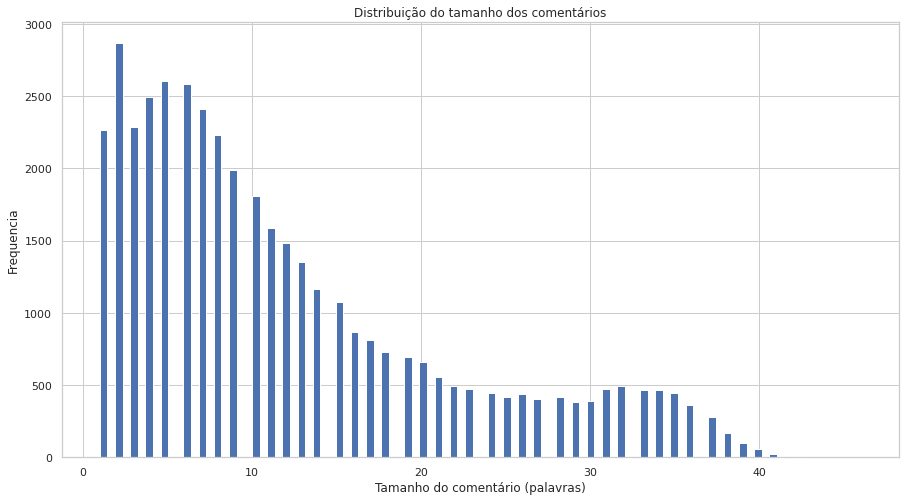

In [42]:
review_data = order_reviews.drop(['review_comment_title'],axis=1).dropna()
words_per_review = review_data.review_comment_message.apply(lambda x: len(x.split(" ")))
plt.figure(figsize=(15,8))
words_per_review.hist(bins = 100)
plt.xlabel('Tamanho do comentário (palavras)')
plt.ylabel('Frequencia')
plt.title('Distribuição do tamanho dos comentários')
plt.show()



Obtêm-se uma distribuição assimétrica à esquerda, mostrando que a mairia dos comentários contém até 10 palavras

###2.2.2 Número de avaliações X Tamanho do comentário X score

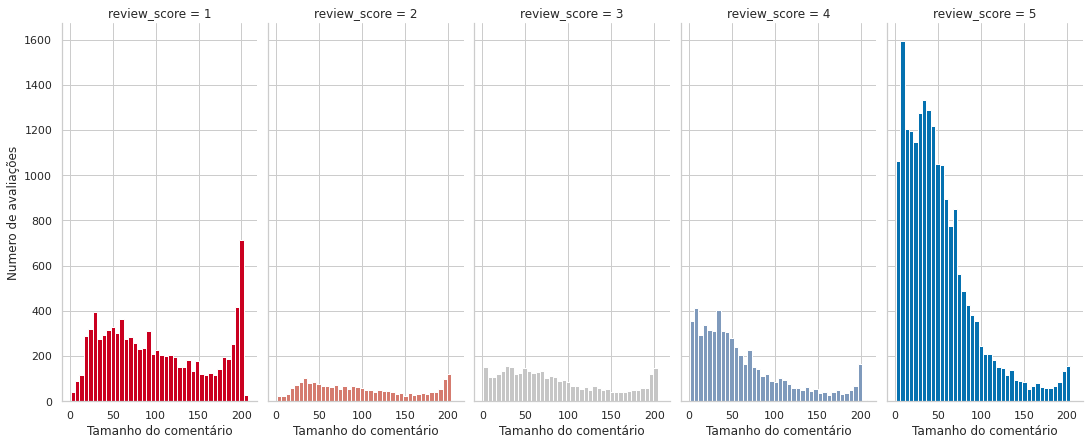

In [43]:
g = sns.FacetGrid(data=reviews, col='review_score', hue='review_score', palette=REVIEWS_PALETTE)
g.map(plt.hist, 'review_length', bins=40)
g.set_xlabels('Tamanho do comentário')
g.set_ylabels('Numero de avaliações')
plt.gcf().set_size_inches(15,8);

Observamos que os clientes insatisfeitos escrevem comentários mais longos e que o número de avaliações é maior entre os clientes satisfeitos

###2.2.3 Taxa de comentário em função do score

Definimos a taxa de comentários como o número de comentários não nulos pelo número de scores

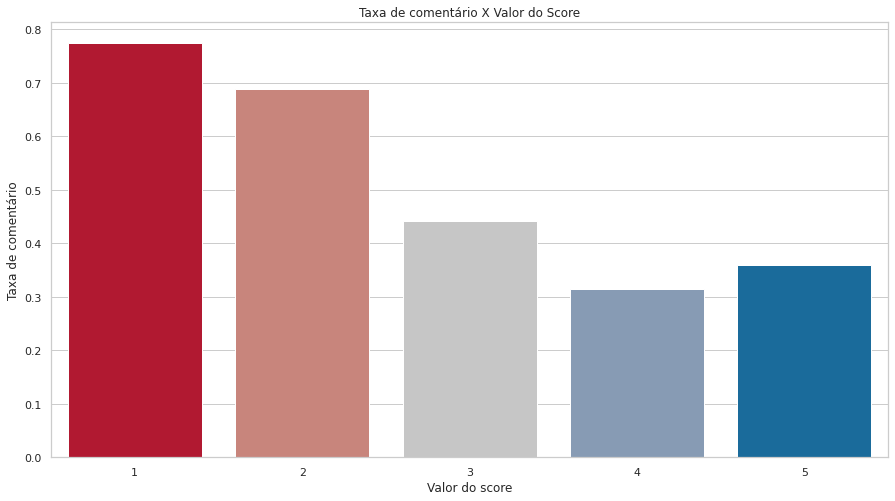

In [44]:
def comment_rate(df):
    return df['review_length'].count() / len(df)

comment_rates = reviews.groupby('review_score').apply(comment_rate)

plt.figure(figsize=(15,8))
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.barplot(x=comment_rates.index, y=comment_rates,palette=REVIEWS_PALETTE
).set(xlabel='Valor do score', ylabel='Taxa de comentário', title='Taxa de comentário X Valor do Score');




Os clientes insatisfeitos possuem uma taxa de comentário maior do que os satisfeitos

###2.2.4 Boxplot Tamanho do comentário em função do score

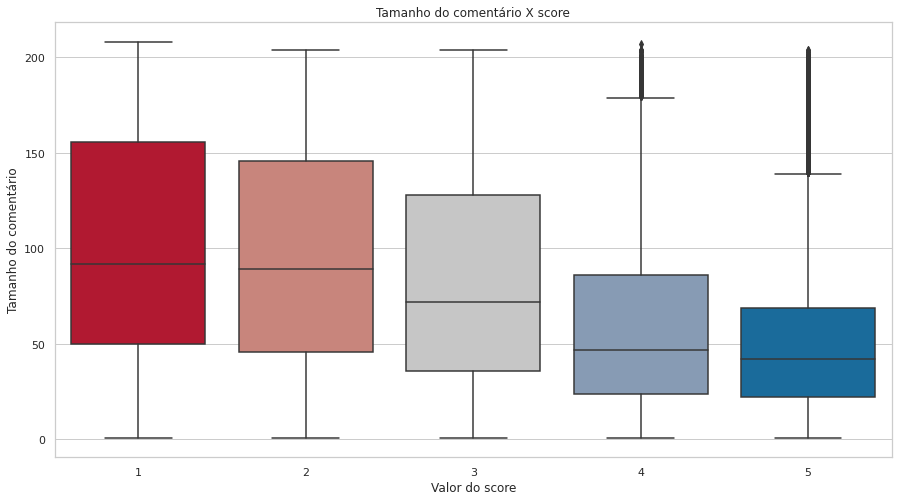

In [45]:
def describe_y_by_x_cat_boxplot(dtf, x_feat, y_target, title='', figsize=(15,8), rotatioon_degree=0):
    fig, ax1 = plt.subplots(figsize = figsize)
    sns.boxplot(x=x_feat, y=y_target, data=dtf, ax=ax1,palette=REVIEWS_PALETTE)
    plt.xticks(rotation=rotatioon_degree)
    plt.title('Tamanho do comentário X score')
    plt.xlabel('Valor do score')
    plt.ylabel('Tamanho do comentário')
    plt.show()


describe_y_by_x_cat_boxplot(reviews, 'review_score', 'review_length', figsize=(15,8),)

###2.2.5 Análise de sentimentos (Nuvem de palavras)

Primeiro vamos separar apenas os comentários e scores 

In [46]:
comments = order_reviews[['review_comment_title','review_comment_message', 'review_score']].dropna()
comments

,review_comment_title,review_comment_message,review_score
9,recomendo,aparelho eficiente. no site a marca do aparelh...,4
15,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",5
19,Não chegou meu produto,Péssimo,1
22,Ótimo,Loja nota 10,5
34,Muito bom.,Recebi exatamente o que esperava. As demais en...,4
...,...,...,...
99962,Nota máxima!,"Muito obrigado,\r\n\r\nExcelente atendimento,b...",5
99967,👍,Aprovado!,4
99971,muito bom produto,"Ficamos muito satisfeitos com o produto, atend...",5
99972,Não foi entregue o pedido,Bom dia \r\nDas 6 unidades compradas só recebi...,3


Agora vamos fazer a limpeza do texto, tornando-as todas minúsculas e retirando acentuação

In [47]:
import string
!pip install Unidecode
import unidecode

def clean_text(txt):
    # Lower characters
    txt = txt.lower()

    for p in string.punctuation:
        txt = txt.replace(p, ' ')
    
    # Remoção de acentos
    txt = unidecode.unidecode(txt)
        
    txt = ' '.join(txt.split())
    return txt


Então aplicamos a limpeza de texto às as colunas de comentários (title e message)

In [48]:
comments.review_comment_message = comments.review_comment_message.apply(clean_text)
comments.review_comment_title = comments.review_comment_title.apply(clean_text)
comments.head()

,review_comment_title,review_comment_message,review_score
9,recomendo,aparelho eficiente no site a marca do aparelho...,4
15,super recomendo,vendedor confiavel produto ok e entrega antes ...,5
19,nao chegou meu produto,pessimo,1
22,otimo,loja nota 10,5
34,muito bom,recebi exatamente o que esperava as demais enc...,4


Agora vamos utilizar a bibliote wordcloud para destacar as palavras mais frequentes nos comentários

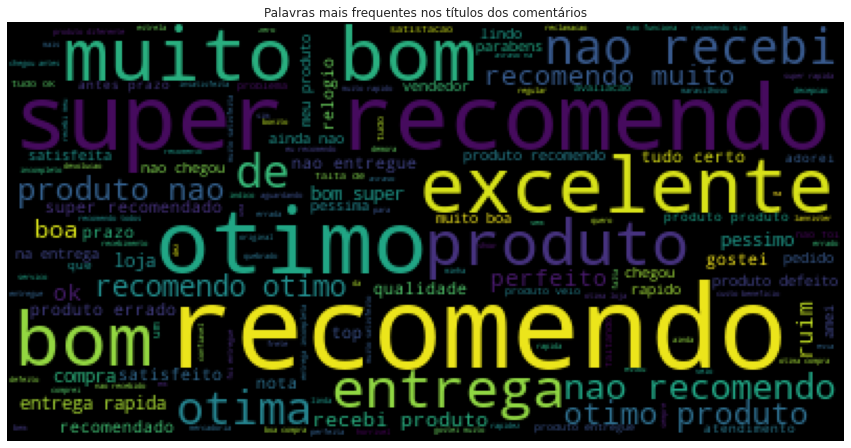

In [49]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud().generate(' '.join(comments.review_comment_title))

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Palavras mais frequentes nos títulos dos comentários')
plt.show()

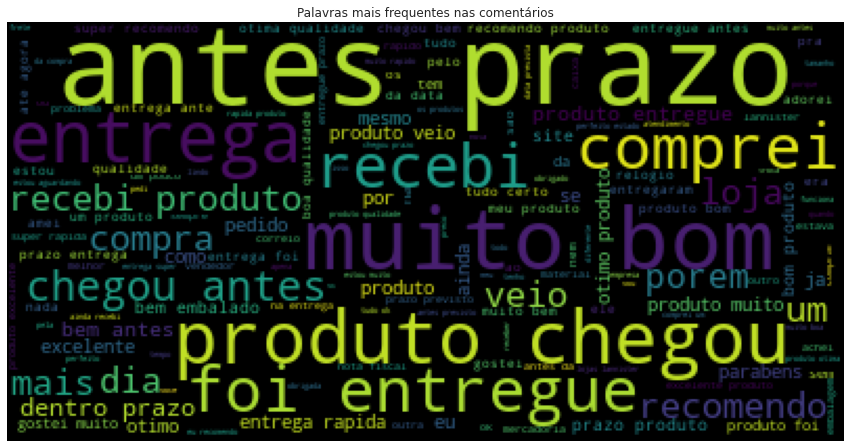

In [50]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)
stopwords.update(['que','de','em','para','ma','nao','mas','uma','esta','pois'])

wordcloud = WordCloud(stopwords=stopwords).generate(' '.join(comments.review_comment_message))

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.title('Palavras mais frequentes nas comentários')
plt.axis("off")
plt.show()

Podemos concluir dizendo que os clientes gostam muito quando a compra chega no prazo. 